In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/BHBikash/FinalDataset/main/Dataset%20O2N.csv')

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=True, inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [ ]:
train_size = int(len(scaled_data) * 0.98)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=1)

In [ ]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 10ms/step


In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
pred_df = pd.DataFrame({'Date': data.index[train_size+sequence_length:], 'Forecasted Price': y_pred.flatten()})

In [ ]:
print("Predicted Values:")
print(pred_df)
print("\nMean Squared Error:", mse)
print("RMSE:", rmse)
print("Mean Absolute Error:", mae)

Predicted Values:
         Date  Forecasted Price
0  2023-04-05        104.784126
1  2023-04-06        105.334297
2  2023-04-10        105.152130
3  2023-04-11        105.121231
4  2023-04-12        105.155144
5  2023-04-13        105.199921
6  2023-04-17        105.233185
7  2023-04-18        105.216347
8  2023-04-24        105.143417
9  2023-04-25        105.094749
10 2023-04-26        105.584633
11 2023-04-27        105.404343
12 2023-05-02        105.244217
13 2023-05-03        105.128021
14 2023-05-08        105.203880
15 2023-05-09        105.447060
16 2023-05-10        105.908241
17 2023-05-11        106.038727
18 2023-05-15        106.091858
19 2023-05-16        106.299416
20 2023-05-17        106.246407
21 2023-05-18        106.197792
22 2023-05-19        106.136574
23 2023-05-22        106.123169
24 2023-05-23        106.074059
25 2023-05-24        106.264030
26 2023-05-25        106.162209
27 2023-05-26        106.077293
28 2023-05-29        106.042549
29 2023-05-30        1

In [ ]:
merged_df = pd.merge(data, pred_df, on='Date', how='inner')

In [ ]:
merged_df['Difference'] = merged_df['Price'] - merged_df['Forecasted Price']

In [ ]:
print(merged_df[['Date', 'Price', 'Forecasted Price', 'Difference']])

         Date    Price  Forecasted Price  Difference
0  2023-04-05  107.400        104.784126    2.615874
1  2023-04-06  105.810        105.334297    0.475703
2  2023-04-10  106.160        105.152130    1.007870
3  2023-04-11  106.280        105.121231    1.158769
4  2023-04-12  106.340        105.155144    1.184856
5  2023-04-13  106.370        105.199921    1.170079
6  2023-04-17  106.250        105.233185    1.016815
7  2023-04-18  106.110        105.216347    0.893653
8  2023-04-24  106.100        105.143417    0.956583
9  2023-04-25  107.500        105.094749    2.405251
10 2023-04-26  106.120        105.584633    0.535367
11 2023-04-27  106.100        105.404343    0.695657
12 2023-05-02  106.060        105.244217    0.815783
13 2023-05-03  106.440        105.128021    1.311979
14 2023-05-08  106.930        105.203880    1.726120
15 2023-05-09  107.740        105.447060    2.292940
16 2023-05-10  107.330        105.908241    1.421759
17 2023-05-11  107.340        106.038727    1.

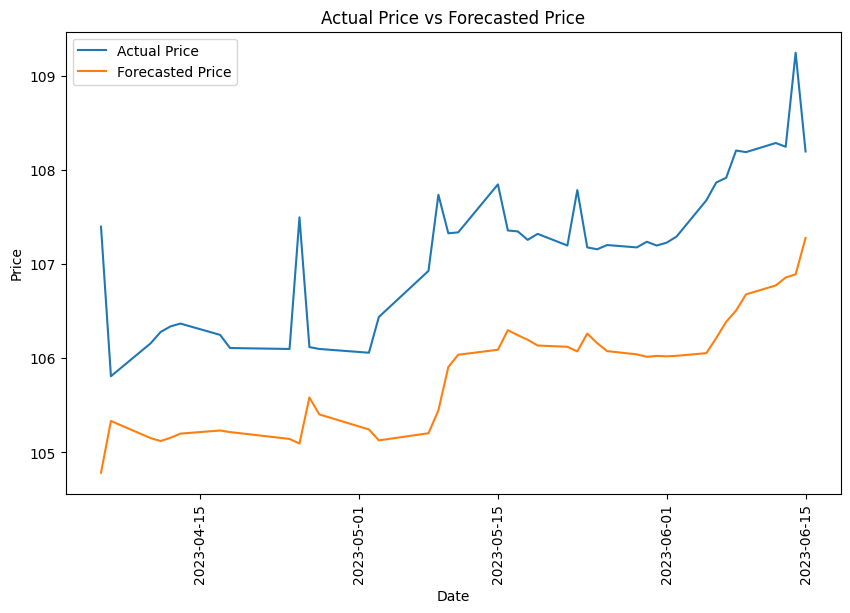

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Price'], label='Actual Price')
plt.plot(merged_df['Date'], merged_df['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Price vs Forecasted Price')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [ ]:
last_sequence = scaled_data[-sequence_length:]

In [ ]:
future_predictions = []

In [ ]:
for _ in range(180):
    next_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_prediction[0][0])
    last_sequence = np.append(last_sequence[1:], next_prediction[0])

In [ ]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [ ]:
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=180, freq='D')

In [ ]:
print(len(future_dates))
print(len(future_predictions))


180
180


In [ ]:
future_df = pd.DataFrame({'Date': future_dates, 'Forecasted Price': future_predictions.flatten()})

In [ ]:
future_df['Date'] = pd.to_datetime(future_df['Date'])

In [ ]:
print("Future Predictions:")
print(future_df)

Future Predictions:
          Date  Forecasted Price
0   2023-06-16        107.134247
1   2023-06-17        106.621918
2   2023-06-18        106.105812
3   2023-06-19        105.613564
4   2023-06-20        105.150192
..         ...               ...
175 2023-12-08         92.959641
176 2023-12-09         92.953461
177 2023-12-10         92.947372
178 2023-12-11         92.941391
179 2023-12-12         92.935516

[180 rows x 2 columns]


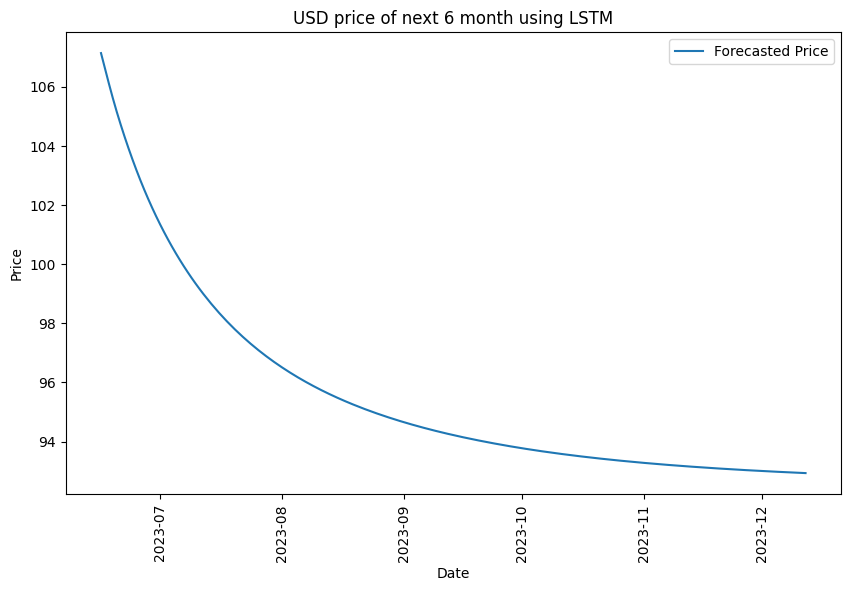

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(future_df['Date'], future_df['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('USD price of next 6 month using LSTM')
plt.legend()
plt.xticks(rotation=90)
plt.show()